In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset
from uav_active_sensing.modeling.img_exploration_env import ImageExplorationEnv, RewardFunction
from uav_active_sensing.modeling.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.plots import visualize_reconstruction

import torch
from torch.utils.data import DataLoader

from transformers import AutoImageProcessor
from ray.rllib.algorithms.ppo import PPOConfig

2025-02-07 16:36:18.404 | INFO     | uav_active_sensing.config:<module>:11 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing


In [22]:
TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


def tiny_imagenet_collate_fn(batch):
    processed_batch = [
        image[0]["pixel_values"].to(DEVICE)
        for image in batch
    ]

    return torch.cat(processed_batch, dim=0)


image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=image_processor
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=image_processor
)
dataloader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn)  # Currently only supports batch size of 1

custom_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
reward_function = RewardFunction(custom_model)

# TODO: Add config that avoids movement in z (fixed kernel size)
env_config = {
    "device": DEVICE,
    "dataloader": dataloader,
    "reward_function": reward_function,
    "patch_size": 16,
    "max_steps": 20,
    "interval_reward_assignment": 10,
    "v_max_x": 10,
    "v_max_y": 10,
    "v_max_z": 0,
}

In [23]:
ppo_config = PPOConfig()
ppo_config.environment(env="ImgExploreEnv-v0", env_config=env_config)
ppo_config.env_runners(num_env_runners=1)
ppo_config.training(
    gamma=0.9, lr=0.01, kl_coeff=0.3, train_batch_size_per_learner=32, minibatch_size=16
)

# Build a Algorithm object from the config
# ppo_algo = ppo_config.build_algo() # TODO: This runs forever
# ppo_algo.train()

### RL trainig with epoch interface

In [24]:
env = ImageExplorationEnv(env_config)

# TODO: Repeat for many epochs until convergence


# First half of the epoch. Train RL agent(s) in env instantiated with each batch

total_reward = 0
for batch in range(len(env.dataloader)):
    terminated = False
    observation, info = env.reset()  # reset loads a new batch into the environment
    print(f"Batch: {batch}")
    # Episode loop
    while not terminated:
        # action = ppo_algo.compute_single_action(observation)
        action = env.action_space.sample()

        next_observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward.detach().numpy()

        if env.step_count % env.interval_reward_assignment == 0:
            print(f"Reward={total_reward}")
            total_reward = 0

        observation = next_observation
    # TODO: Store batch sampled images paired with actual images.
    # We need a dataloader that returns pairs of images for MAE fine tuning during the second half of the epoch

    if batch == 2:
        break

# TODO: Second half of the epoch. Train MAE here with pairs of batches of sampled and complete images

env.close()

Epoch: 0
Reward=0.43391627073287964
Reward=0.42824530601501465
Epoch: 1
Reward=0.5280410051345825
Reward=0.5793390274047852
Epoch: 2
Reward=0.43006160855293274
Reward=0.3976394534111023


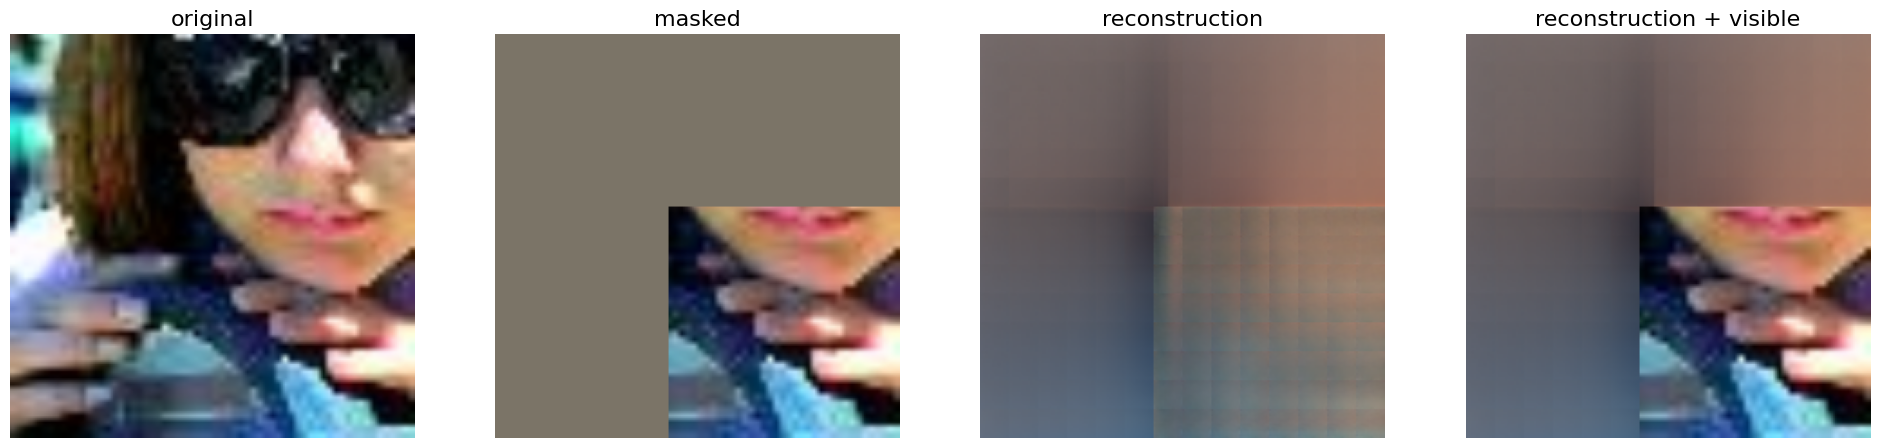

In [25]:
visualize_reconstruction(env.img[0].unsqueeze(0), env.sampled_img[0].unsqueeze(0), custom_model)